In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

assets = {
    'Asset A': {'mu': 0.08, 'sigma': 0.15},
    'Asset B': {'mu': 0.12, 'sigma': 0.20},
    'Asset C': {'mu': 0.10, 'sigma': 0.18},
}

n_days = 252
n_simulations = 1000

returns = {}
for asset, stats in assets.items():
    mu_daily = stats['mu'] / n_days
    sigma_daily = stats['sigma'] / np.sqrt(n_days)
    simulated_returns = np.random.normal(mu_daily, sigma_daily, (n_simulations, n_days))
    returns[asset] = simulated_returns

df_returns = {k: pd.DataFrame(v) for k, v in returns.items()}

df_returns['Asset A'].head()


,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,0.005011,-0.000989,0.006438,0.014709,-0.001895,-0.001895,0.015240,0.007569,-0.004119,0.005444,...,0.005089,0.008498,-0.011024,-0.002843,-0.004170,-0.005856,0.016999,0.004144,-0.011597,0.008990
1,0.020370,0.010073,-0.014039,-0.004258,0.012289,-0.006369,0.004511,0.007637,-0.008441,-0.000245,...,0.014710,0.005410,-0.009484,-0.001481,-0.007956,-0.012749,0.009069,0.018360,-0.012898,0.005637
2,-0.005831,-0.004285,-0.005280,-0.007846,0.000776,-0.007534,0.002873,-0.000157,-0.001940,-0.008258,...,0.002082,-0.006820,-0.005461,-0.012974,-0.008406,-0.012455,-0.008904,0.010273,-0.008654,0.025191
3,0.004979,0.002064,-0.007793,0.006935,-0.005122,0.001470,0.024508,-0.000590,0.011177,-0.006327,...,-0.005080,0.005728,0.013540,0.009054,0.000881,-0.005796,0.006915,0.004036,0.008776,0.006319
4,0.010235,-0.004740,0.012766,0.002185,0.019927,-0.006195,0.016721,0.002188,-0.005838,-0.004255,...,0.003444,0.008194,-0.018522,0.003852,0.011918,-0.011113,0.016122,0.004277,-0.006344,-0.000210


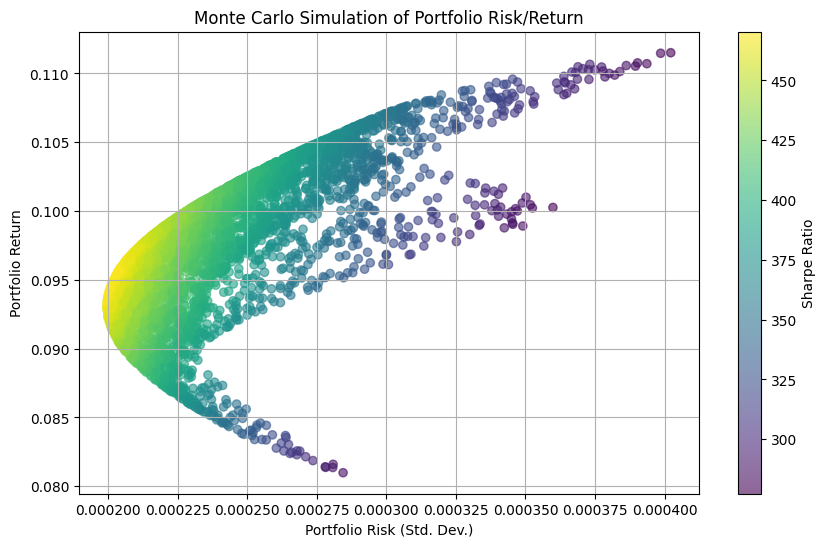

In [2]:
n_portfolios = 5000

port_returns = []
port_risks = []
port_weights = []

mean_returns = np.array([df.mean().mean() * n_days for df in df_returns.values()])
cov_matrix = np.cov([df.mean(axis=0) for df in df_returns.values()])

for _ in range(n_portfolios):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    port_weights.append(weights)

    port_return = np.dot(weights, mean_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    port_returns.append(port_return)
    port_risks.append(port_risk)

portfolio_df = pd.DataFrame({
    'Return': port_returns,
    'Risk': port_risks,
    'Asset A Weight': [w[0] for w in port_weights],
    'Asset B Weight': [w[1] for w in port_weights],
    'Asset C Weight': [w[2] for w in port_weights],
})

plt.figure(figsize=(10, 6))
plt.scatter(portfolio_df['Risk'], portfolio_df['Return'], c=portfolio_df['Return'] / portfolio_df['Risk'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Risk (Std. Dev.)')
plt.ylabel('Portfolio Return')
plt.title('Monte Carlo Simulation of Portfolio Risk/Return')
plt.grid(True)
plt.show()


In [3]:
from scipy.optimize import minimize

def neg_portfolio_return(weights, mean_returns):
    return -np.dot(weights, mean_returns)

def weight_constraint(weights):
    return np.sum(weights) - 1

def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

init_guess = [1/3, 1/3, 1/3]

bounds = tuple((0, 1) for _ in range(3))

constraints = [{'type': 'eq', 'fun': weight_constraint}]

opt_result = minimize(
    fun=neg_portfolio_return,
    x0=init_guess,
    args=(mean_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = opt_result.x
opt_return = -opt_result.fun
opt_risk = portfolio_risk(opt_weights, cov_matrix)

print("Optimized Portfolio Weights:")
for asset, weight in zip(assets, opt_weights):
    print(f"{asset}: {weight:.2%}")

print(f"\nExpected Annual Return: {opt_return:.2%}")
print(f"Expected Risk (Std. Dev.): {opt_risk:.2%}")


Optimized Portfolio Weights:
Asset A: 0.00%
Asset B: 100.00%
Asset C: 0.00%

Expected Annual Return: 11.19%
Expected Risk (Std. Dev.): 0.04%


In [4]:
n_scenarios = 1000
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_scenarios)

def expected_neg_return(weights, scenarios):
    portfolio_returns = scenarios @ weights
    return -np.mean(portfolio_returns)

constraints = [{'type': 'eq', 'fun': weight_constraint}]
bounds = tuple((0, 1) for _ in range(3))
init_guess = [1/3, 1/3, 1/3]

stoch_result = minimize(
    fun=expected_neg_return,
    x0=init_guess,
    args=(simulated_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

stoch_weights = stoch_result.x
stoch_return = -stoch_result.fun
stoch_risk = portfolio_risk(stoch_weights, cov_matrix)

print("Stochastic Programming Portfolio Weights:")
for asset, weight in zip(assets, stoch_weights):
    print(f"{asset}: {weight:.2%}")

print(f"\nExpected Return Across Scenarios: {stoch_return:.2%}")
print(f"Expected Risk (Std. Dev.): {stoch_risk:.2%}")


Stochastic Programming Portfolio Weights:
Asset A: 0.00%
Asset B: 100.00%
Asset C: 0.00%

Expected Return Across Scenarios: 11.19%
Expected Risk (Std. Dev.): 0.04%


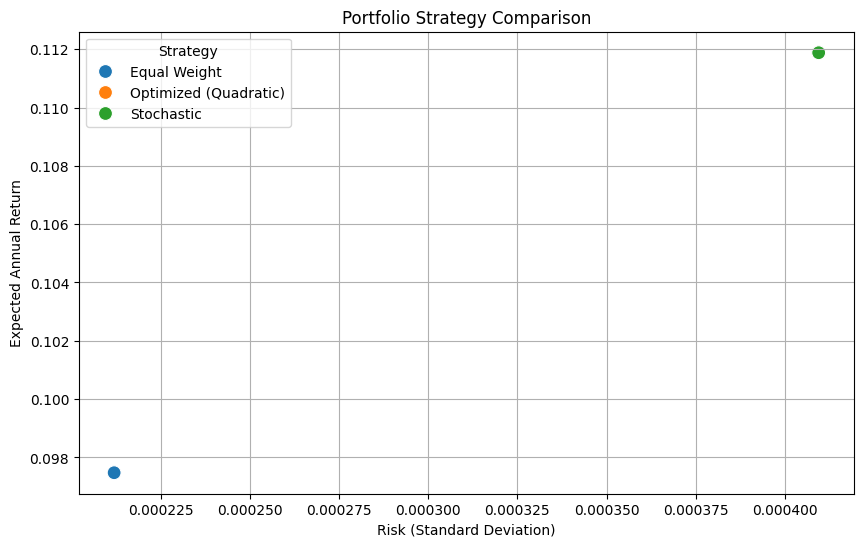

,Strategy,Expected Return,Risk
0,Equal Weight,0.097475,0.000212
1,Optimized (Quadratic),0.111879,0.000409
2,Stochastic,0.111879,0.000409


In [8]:
equal_weights = np.array([1/3, 1/3, 1/3])

strategies = {
    'Equal Weight': equal_weights,
    'Optimized (Quadratic)': opt_weights,
    'Stochastic': stoch_weights
}

summary = []
for name, w in strategies.items():
    port_return = np.dot(w, mean_returns)
    port_risk = portfolio_risk(w, cov_matrix)
    summary.append({'Strategy': name, 'Expected Return': port_return, 'Risk': port_risk})

summary_df = pd.DataFrame(summary)

plt.figure(figsize=(10,6))
sns.scatterplot(data=summary_df, x='Risk', y='Expected Return', hue='Strategy', s=100)
plt.title('Portfolio Strategy Comparison')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.grid(True)
plt.show()

summary_df
